In [1]:
!pip install matplotlib basemap
!pip install cartopy

  Using cached basemap-1.3.7-cp310-cp310-manylinux1_x86_64.whl (860 kB)
  Using cached basemap_data-1.3.2-py2.py3-none-any.whl (30.5 MB)


In [12]:
import pandas as pd
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import fsspec
import gcsfs
import os
import math
import shap
import tables
import dask.dataframe as dd
import xarray as xr
import numpy as np
import requests
import time
from PIL import Image
import matplotlib.pyplot as plt
import cartopy

gt_id='contest_tmp2m' #'contest_tmp2m' or 'contest_precip'
target_horizon='56w' #'56w' or '34w'

from experiments_util import *
# Load functionality for fitting and predicting
from fit_and_predict import *
# Load functionality for evaluation
from skill import *
# Load stepwise utility functions
from stepwise_util import *

In [3]:
file_path = "data/clusters coordinates/koppen_1901-2010.tsv"

# Importer le fichier TSV en tant que DataFrame
df = pd.read_csv(file_path, delimiter='\t')

# Afficher le DataFrame
print(df)

       longitude  latitude p1901_2010
0        -179.75     71.25         ET
1        -179.75     68.75         ET
2        -179.75     68.25         ET
3        -179.75     67.75         ET
4        -179.75     67.25         ET
...          ...       ...        ...
85789     179.75    -87.75         EF
85790     179.75    -88.25         EF
85791     179.75    -88.75         EF
85792     179.75    -89.25         EF
85793     179.75    -89.75         EF

[85794 rows x 3 columns]


In [4]:
data=pd.read_hdf('results/regression/shared/contest_tmp2m_56w/lat_lon_date_data-contest_tmp2m_56w.h5')

In [5]:
df_climate_zones=df[(df['longitude']>=-125)&(df['longitude']<=-93)&(df['latitude']>=26)&(df['latitude']<=50)]
df_climate_zones.reset_index(inplace=True,drop=True)
df_climate_zones['longitude']=df_climate_zones['longitude']+360
df_climate_zones = df_climate_zones.sort_values(by=['latitude', 'longitude'])
df_climate_zones['latitude'] = df_climate_zones['latitude'].astype(float)
df_climate_zones['longitude'] = df_climate_zones['longitude'].astype(float)
df_climate_zones['Large region'] = df_climate_zones['p1901_2010'].apply(lambda x: x[0])

print(df_climate_zones)

      longitude  latitude p1901_2010 Large region
820      247.75     26.25        BWh            B
865      248.25     26.25        BWh            B
1141     251.25     26.25        BSh            B
1189     251.75     26.25        BSh            B
1237     252.25     26.25        Csa            C
...         ...       ...        ...          ...
2371     264.75     49.75        Dfb            D
2413     265.25     49.75        Dfb            D
2453     265.75     49.75        Dfb            D
2494     266.25     49.75        Dfb            D
2535     266.75     49.75        Dfb            D

[2575 rows x 4 columns]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
df_climate_zones['latitude'] = df_climate_zones['latitude'].apply(lambda x: round(x) if round(x % 1, 2) == 0.25 else x)
df_climate_zones['longitude'] = df_climate_zones['longitude'].apply(lambda x: round(x) if round(x % 1, 2) == 0.25 else x)
df_climate_zones.rename(columns={'latitude':'lat','longitude':'lon'},inplace=True)
print(df_climate_zones)

         lon    lat p1901_2010 Large region
820   247.75  26.00        BWh            B
865   248.00  26.00        BWh            B
1141  251.00  26.00        BSh            B
1189  251.75  26.00        BSh            B
1237  252.00  26.00        Csa            C
...      ...    ...        ...          ...
2371  264.75  49.75        Dfb            D
2413  265.00  49.75        Dfb            D
2453  265.75  49.75        Dfb            D
2494  266.00  49.75        Dfb            D
2535  266.75  49.75        Dfb            D

[2575 rows x 4 columns]


In [7]:
data=data.sort_values(by=['start_date'])
coordinates=data[['lat','lon']][0:514]
coordinates=coordinates.sort_values(by=['lat','lon'])
coordinates.reset_index(inplace=True,drop=True)
print(coordinates)

      lat    lon
0    27.0  261.0
1    27.0  262.0
2    28.0  261.0
3    28.0  262.0
4    28.0  263.0
..    ...    ...
509  49.0  258.0
510  49.0  259.0
511  49.0  260.0
512  49.0  261.0
513  49.0  262.0

[514 rows x 2 columns]


In [8]:
df_coordinates=pd.merge(coordinates,df_climate_zones,on=['lat','lon'],how='left')
print(coordinates)

      lat    lon p1901_2010 Large region
0    27.0  261.0        BSh            B
1    27.0  262.0        Cfa            C
2    28.0  261.0        BSh            B
3    28.0  262.0        Cfa            C
4    28.0  263.0        NaN          NaN
..    ...    ...        ...          ...
509  49.0  258.0        Dfb            D
510  49.0  259.0        Dfb            D
511  49.0  260.0        Dfb            D
512  49.0  261.0        Dfb            D
513  49.0  262.0        Dfb            D

[514 rows x 4 columns]


In [9]:
def transform_large_region(row):
    if row['Large region']=='C':
        if row['lon'] < 240 or (row['lon'] >= 250 and row['lat'] < 31):
            return 'Co'
        else:
            return 'Cc'
    else:
        return row['Large region']

coordinates['Large region'] = coordinates.apply(transform_large_region, axis=1)

In [46]:
print(coordinates[coordinates['lon']<240][['lat','lon','Large region']])

      lat    lon Large region
125  36.0  239.0           Co
152  37.0  238.0           Co
153  37.0  239.0           Co
180  38.0  238.0           Co
181  38.0  239.0           Co
208  39.0  237.0           Co
209  39.0  238.0           Co
210  39.0  239.0           Co
237  40.0  236.0           Co
238  40.0  237.0           Co
239  40.0  238.0           Co
240  40.0  239.0           Co
266  41.0  236.0           Co
267  41.0  237.0           Co
268  41.0  238.0           Co
269  41.0  239.0           Co
295  42.0  236.0           Co
296  42.0  237.0           Co
297  42.0  238.0           Co
298  42.0  239.0           Co
323  43.0  236.0           Co
324  43.0  237.0           Co
325  43.0  238.0           Co
326  43.0  239.0           Co
351  44.0  236.0           Co
352  44.0  237.0           Co
353  44.0  238.0           Co
354  44.0  239.0           Co
379  45.0  236.0           Co
380  45.0  237.0           Co
381  45.0  238.0           Co
382  45.0  239.0           Co
407  46.0 

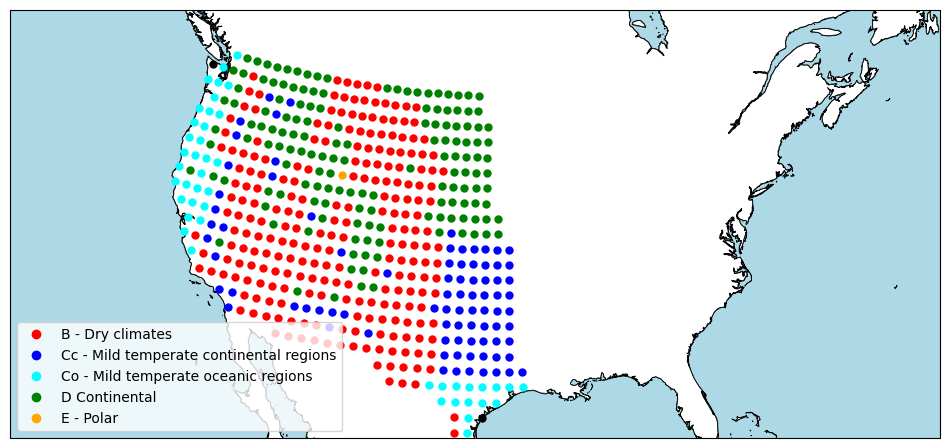

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

map = ccrs.LambertConformal(central_longitude=-95, central_latitude=37.5, standard_parallels=(33, 45))

plt.figure(figsize=(12, 8))

ax = plt.axes(projection=map)
ax.set_extent([-130, -65, 23, 50])
ax.coastlines(resolution='10m', color='black', linewidth=0.5)
ax.add_feature(cartopy.feature.LAND, facecolor='white', edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')

zone_colors = {
    'B': 'red',
    'Cc':'blue',
    'Co': 'cyan',
    'D': 'green',
    'E': 'orange'
}

for index, row in coordinates.iterrows():
    lat = row['lat']
    lon = row['lon']
    climate_zone = row['Large region']

    ax.plot(lon, lat, marker='o', color=zone_colors.get(climate_zone, 'black'), markersize=5, transform=ccrs.PlateCarree())
    
legend_labels = ['B - Dry climates', 'Cc - Mild temperate continental regions', 'Co - Mild temperate oceanic regions','D Continental', 'E - Polar']
legend_colors = ['red', 'blue', 'cyan','green', 'orange']
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, label=label, linestyle='') for label, color in zip(legend_labels, legend_colors)]
ax.legend(handles=legend_elements, loc='lower left')

# Afficher la carte
plt.show()


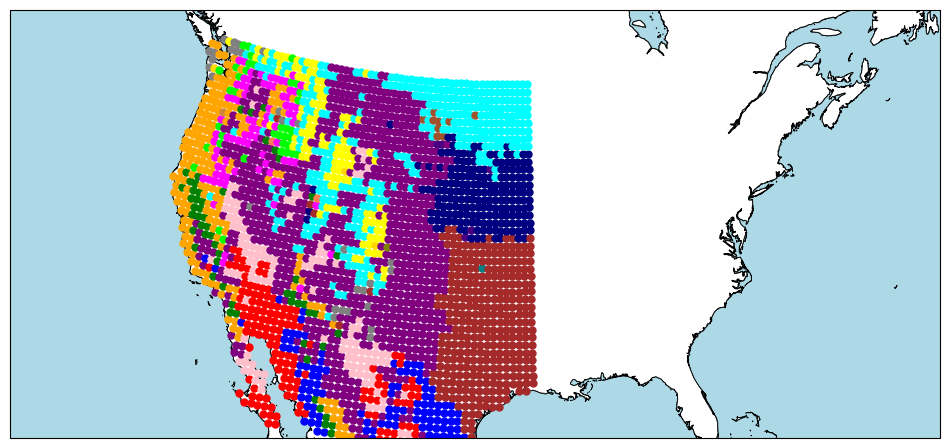

In [75]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

map = ccrs.LambertConformal(central_longitude=-95, central_latitude=37.5, standard_parallels=(33, 45))

plt.figure(figsize=(12, 8))

ax = plt.axes(projection=map)
ax.set_extent([-130, -65, 23, 50])
ax.coastlines(resolution='10m', color='black', linewidth=0.5)
ax.add_feature(cartopy.feature.LAND, facecolor='white', edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')

zone_colors = {
    'BWh': 'red',
    'BSh': 'blue',
    'Csa': 'green',
    'Csb': 'orange',
    'BSk': 'purple',
    'BWk': 'pink',
    'Cfa': 'brown',
    'Cfb': 'gray',
    'Dfb': 'cyan',
    'Dsb': 'magenta',
    'Dfc': 'yellow',
    'Dsc': 'lime',
    'Cwa': 'teal',
    'ET': 'gold',
    'Cwb': 'olive',
    'Dfa': 'navy',
    'Dwa': 'indigo',
    'Dsa': 'coral',
    'Csc': 'peru',
    'Dwb': 'sienna'
}

for index, row in df_climate_zones.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    climate_zone = row['p1901_2010']

    ax.plot(lon, lat, marker='o', color=zone_colors.get(climate_zone, 'black'), markersize=5, transform=ccrs.PlateCarree())

plt.show()


In [73]:
print(df_climate_zones['p1901_2010'].unique())

['BWh' 'BSh' 'Csa' 'Csb' 'BSk' 'BWk' 'Cfa' 'Cfb' 'Dfb' 'Dsb' 'Dfc' 'Dsc'
 'Cwa' 'ET' 'Cwb' 'Dfa' 'Dwa' 'Dsa' 'Csc' 'Dwb']


<div align="center">
    <h1><strong>Archives</strong></h1>
</div>

In [2]:
def get_zone_color(image_path, coordinates):
    # Charger l'image TIFF avec PIL
    Image.MAX_IMAGE_PIXELS = None
    image = Image.open(image_path)

    lat, lon = coordinates
    x = int(lon * (image.width / 360))
    y = int((90 - lat) * (image.height / 180))

    pixel_color = image.getpixel((x, y))

    if isinstance(pixel_color, int):
        pixel_color_rgb = (pixel_color, pixel_color, pixel_color)
    else:
        pixel_color_rgb = tuple(pixel_color[:3])

    return pixel_color_rgb

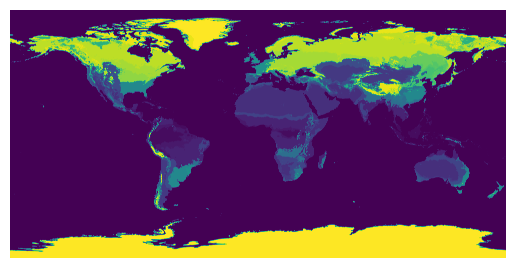

In [15]:
Image.MAX_IMAGE_PIXELS=None
mapp=Image.open('data/clusters coordinates/Beck_KG_V1_present_0p0083.tif')
Image.MAX_IMAGE_PIXELS=None



# Afficher l'image rognée
map_array = np.array(mapp)

plt.imshow(map_array)  # Utilisez 'gray' si votre image est en niveaux de gris
plt.axis('off')  # Supprimer les axes
plt.show()

#this map shows the climate regions of the rodeo dataset zone

In [8]:
image_path='data/clusters coordinates/Beck_KG_V1_present_0p0083.tif'
def create_clusters(image_path,visited_pairs):
    clusters={}
    for couple in visited_pairs:
        if get_zone_color(image_path,couple) not in list(clusters.keys()):
            clusters[get_zone_color(image_path,couple)]=[]
            clusters[get_zone_color(image_path,couple)].append(couple)
        else:
            clusters[get_zone_color(image_path,couple)].append(couple)
    return clusters

In [16]:
print(visited_pairs)

{(38.0, 261.0), (49.0, 261.0), (42.0, 240.0), (42.0, 249.0), (30.0, 256.0), (42.0, 258.0), (30.0, 265.0), (39.0, 243.0), (39.0, 252.0), (31.0, 257.0), (34.0, 259.0), (45.0, 259.0), (37.0, 264.0), (46.0, 242.0), (38.0, 238.0), (49.0, 238.0), (46.0, 251.0), (38.0, 247.0), (49.0, 247.0), (46.0, 260.0), (38.0, 256.0), (49.0, 256.0), (38.0, 265.0), (42.0, 244.0), (42.0, 253.0), (30.0, 260.0), (39.0, 238.0), (34.0, 245.0), (45.0, 245.0), (34.0, 254.0), (45.0, 254.0), (37.0, 250.0), (34.0, 263.0), (45.0, 263.0), (37.0, 259.0), (46.0, 237.0), (46.0, 246.0), (38.0, 242.0), (49.0, 242.0), (46.0, 255.0), (38.0, 251.0), (49.0, 251.0), (38.0, 260.0), (49.0, 260.0), (42.0, 239.0), (42.0, 248.0), (41.0, 252.0), (41.0, 261.0), (33.0, 257.0), (44.0, 257.0), (45.0, 240.0), (34.0, 249.0), (45.0, 249.0), (37.0, 245.0), (34.0, 258.0), (45.0, 258.0), (37.0, 254.0), (37.0, 263.0), (46.0, 241.0), (46.0, 250.0), (38.0, 246.0), (49.0, 246.0), (38.0, 255.0), (49.0, 255.0), (29.0, 264.0), (40.0, 264.0), (41.0, 24

In [47]:
test_pairs={(38.0, 261.0), (49.0, 261.0), (42.0, 240.0)}#,(47.0, 245.0), (42.0, 243.0)}

In [49]:
t=time.time()
clusters=create_clusters(image_path,visited_pairs)
print('Elapsed time=',time.time()-t)
print(clusters)

Elapsed time= 709.4345271587372
{(5, 5, 5): [(38.0, 261.0), (42.0, 240.0), (39.0, 243.0), (37.0, 264.0), (46.0, 242.0), (38.0, 238.0), (46.0, 251.0), (38.0, 247.0), (38.0, 256.0), (38.0, 265.0), (42.0, 244.0), (39.0, 238.0), (45.0, 245.0), (45.0, 254.0), (45.0, 263.0), (37.0, 259.0), (46.0, 237.0), (46.0, 246.0), (38.0, 242.0), (49.0, 242.0), (46.0, 255.0), (38.0, 260.0), (42.0, 239.0), (41.0, 252.0), (41.0, 261.0), (45.0, 240.0), (34.0, 249.0), (45.0, 249.0), (37.0, 263.0), (46.0, 241.0), (46.0, 250.0), (49.0, 246.0), (38.0, 255.0), (40.0, 264.0), (44.0, 252.0), (44.0, 261.0), (45.0, 244.0), (37.0, 240.0), (45.0, 253.0), (45.0, 262.0), (37.0, 258.0), (38.0, 241.0), (40.0, 259.0), (41.0, 242.0), (44.0, 238.0), (41.0, 251.0), (44.0, 247.0), (41.0, 260.0), (45.0, 239.0), (45.0, 248.0), (48.0, 240.0), (48.0, 249.0), (40.0, 245.0), (40.0, 263.0), (41.0, 237.0), (41.0, 246.0), (44.0, 242.0), (44.0, 251.0), (41.0, 264.0), (44.0, 260.0), (45.0, 243.0), (36.0, 261.0), (48.0, 244.0), (40.0, 240

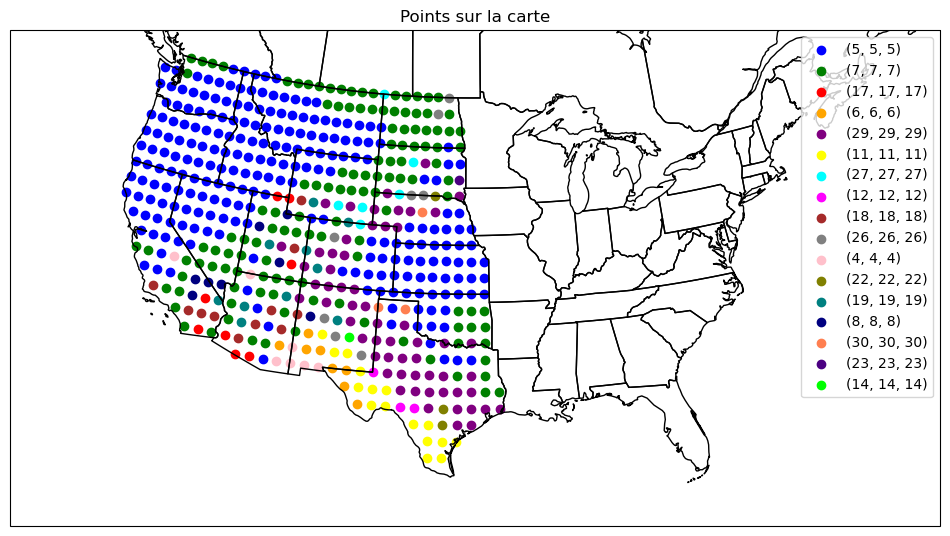

In [50]:



import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.feature as cfeature


fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.LambertConformal()})

# Définir la zone d'affichage de la carte sur les États-Unis
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

# Charger les limites des États-Unis avec cartopy
ax.add_feature(cartopy.feature.STATES)


colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'brown', 'gray', 'pink', 'olive', 'teal', 'navy', 'coral', 'indigo', 'lime']

# Tracer les points pour chaque clé du dictionnaire
for i, key in enumerate(clusters.keys()):
    points = clusters[key]
    latitudes = [point[0] for point in points]
    longitudes = [point[1] for point in points]
    ax.scatter(longitudes, latitudes, color=colors[i], marker='o', transform=ccrs.PlateCarree())

# Ajouter une légende pour les clés du dictionnaire
legend_labels = list(clusters.keys())
ax.legend(legend_labels)

# Ajouter un titre à la carte
ax.set_title('Points sur la carte')

# Afficher la carte
plt.show()






